In [1]:
import sys
sys.path.append('../..')
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch

from DLBio.pytorch_helpers import get_device

import numpy as np
import matplotlib.pyplot as plt
import ds_ear_siamese
import transforms_data as td
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from torch import cuda

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# Set Up All Configurations here
class Config():
    dataset_dir = '../faces/'
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 20
    LEARNINGRATE = 0.001
    WEIGHT_DECAY = 0.1

In [4]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_70]
test_indices = rand_indices[n_70:]

# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform? 
    data_path=Config.dataset_dir
)

# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    indices=test_indices,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

vis_dataloader = ds_ear_siamese.get_dataloader(
        indices=train_indices,
        batch_size=Config.vis_batch_size,
        num_workers=Config.num_workers,
        transform_mode='siamese',
        data_path=Config.dataset_dir
)

['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's5', 's6', 's7', 's8', 's9']
398


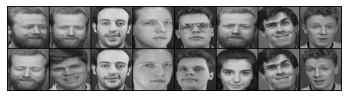

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [5]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
# Definde Model and load to device
model = mobilenet_v2(pretrained=True)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=32)

device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss()
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE,weight_decay=Config.WEIGHT_DECAY)

cpu


In [ ]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, 
                loss_contrastive=contrastive_loss_siamese)

counter, loss_history = training(Config.EPOCHS)
show_plot(counter, loss_history)

In [ ]:
unnormalize = td.UnNormalize()
dataiter = iter(test_dataloader)
accuracy = 0.0
for i in range(30):
    x0,x1,label = next(dataiter)
    while True:
        #keep looping till a different class image is found
        x2,x3,label2 = next(dataiter)
        if label != label2:
            break

    concatenated = torch.cat((unnormalize(x0), unnormalize(x1)),0)
    if cuda.is_available():
        output1 = model(Variable(x0).cuda())
        output2 = model(Variable(x1).cuda())
        output3 = model(Variable(x2).cuda())
        output4 = model(Variable(x3).cuda())
        
    else:
        output1 = model(Variable(x0))
        output2 = model(Variable(x1))
        output3 = model(Variable(x2))
        output4 = model(Variable(x3))
    euclidean_distance_pp = F.pairwise_distance(output1, output2)
    euclidean_distance_pn = F.pairwise_distance(output3, output4)

    
    if(euclidean_distance_pp < euclidean_distance_pn):
        accuracy += 1
        print(euclidean_distance_pp.item())
        print(euclidean_distance_pn.item())
        print(accuracy)
        print(" ")
print(accuracy/30)

In [ ]:
unnormalize = td.UnNormalize()
dataiter = iter(test_dataloader)
for i in range(10):
    x0,x1,label = next(dataiter)
    concatenated = torch.cat((unnormalize(x0), unnormalize(x1)),0)
    if cuda.is_available():
        output1 = model(Variable(x0).cuda())
        output2 = model(Variable(x1).cuda())
    else:
        output1 = model(Variable(x0))
        output2 = model(Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    print(label)

In [ ]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [ ]:
#torch.save(model,'/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')